# Generation of the typical days

Typical days are a way to represent the variability of energy demand and generation over a year by selecting a few representative days. This approach allows for a more computionally manageable analysis while still capturing the stochasticity of the energy system (renewable energy, demand, etc.).

Reference: 
- [Limpens et al. (2019)](https://doi.org/10.1016/j.apenergy.2019.113729)
- [Thiran et al (2023)](https://www.mdpi.com/1996-1073/16/6/2772)

In [2]:
import pickle
from amplpy import AMPL, ampl_notebook
import pandas as pd
import numpy as np  
from energyscope.energyscope import Energyscope
from energyscope.models import core
import sys
sys.path.append('tutorial_input/td-generation')
from td_dat_file_generation import td_dat_file_generation


In [3]:
# Enter nb of TD 
nbr_td = 12

path_td_data = 'tutorial_input/td-generation/'

In [4]:
#1.
#  Load TS ,csv 

time_series = pd.read_csv(path_td_data+'Time_series.csv', sep=';', header=0, index_col=0)
time_series

,Electricity (%_elec),Space Heating (%_sh),Passanger mobility (%_pass),Freight mobility (%_freight),PV,Wind_onshore,Wind_offshore,Hydro_river,Solar
{PERIODS},,,,,,,,,
1,0.000091,0.000131,0.000006,0.000114,0.0,0.157758,0.714385,0.368088,0.0
2,0.000071,0.000123,0.000002,0.000114,0.0,0.182758,0.691530,0.367840,0.0
3,0.000053,0.000128,0.000001,0.000114,0.0,0.192562,0.729855,0.367611,0.0
4,0.000038,0.000130,0.000014,0.000114,0.0,0.211292,0.747715,0.367363,0.0
5,0.000031,0.000131,0.000038,0.000114,0.0,0.290588,0.578893,0.367124,0.0
...,...,...,...,...,...,...,...,...,...
8756,0.000125,0.000263,0.000088,0.000114,0.0,0.450231,0.934246,0.290029,0.0
8757,0.000108,0.000264,0.000059,0.000114,0.0,0.526405,0.932407,0.290076,0.0
8758,0.000098,0.000268,0.000038,0.000114,0.0,0.562126,0.926450,0.290134,0.0


In [5]:
# 2.     compute_cell_w(all_data, weights)
ts = time_series.copy()
# renaming columns to match the expected format
ts.rename(columns={'Electricity (%_elec)': 'LIGHTING', 'Space Heating (%_sh)': 'HEAT_LOW_T_SH'}, inplace=True)
ts_names = ts.columns
# normalize the timeseries
ts = ts/ts.sum()
# adding columns for pivoting
ts['Days'] = np.repeat(np.arange(1, 366), 24, axis=0)
ts['H_of_D'] = np.resize(np.arange(1, 25), ts.shape[0])
# pivoting normalized time series (norm_ts) to get daily normalized time series (n_daily_ts)
n_daily_ts = ts.pivot(index='Days', columns='H_of_D', values=ts_names)
n_daily_ts.fillna(0)

LIGHTING                                                              \
H_of_D        1         2         3         4         5         6         7    
Days                                                                           
1       0.000091  0.000071  0.000053  0.000038  0.000031  0.000030  0.000032   
2       0.000066  0.000048  0.000033  0.000024  0.000026  0.000041  0.000071   
3       0.000106  0.000079  0.000068  0.000058  0.000059  0.000073  0.000100   
4       0.000109  0.000086  0.000068  0.000061  0.000058  0.000058  0.000068   
5       0.000095  0.000075  0.000058  0.000051  0.000049  0.000049  0.000057   
...          ...       ...       ...       ...       ...       ...       ...   
361     0.000105  0.000087  0.000072  0.000061  0.000058  0.000058  0.000065   
362     0.000111  0.000093  0.000080  0.000067  0.000061  0.000060  0.000066   
363     0.000115  0.000098  0.000083  0.000073  0.000069  0.000076  0.000098   
364     0.000113  0.000094  0.000076  0.000066  0.000065  0.000075  0.000097   
365     0.000110  0.000089  0.000071  0.000062  0.000059  0.000064  0.000082   

                                      ...     Solar                           \
H_of_D        8         9         10  ...        15        16   17   18   19   
Days                                  ...                                      
1       0.000023  0.000024  0.000029  ...  0.000000  0.000000  0.0  0.0  0.0   
2       0.000093  0.000118  0.000135  ...  0.000859  0.000380  0.0  0.0  0.0   
3       0.000122  0.000145  0.000155  ...  0.000023  0.000008  0.0  0.0  0.0   
4       0.000076  0.000098  0.000114  ...  0.000052  0.000184  0.0  0.0  0.0   
5       0.000058  0.000073  0.000086  ...  0.000000  0.000000  0.0  0.0  0.0   
...          ...       ...       ...  ...       ...       ...  ...  ...  ...   
361     0.000071  0.000089  0.000107  ...  0.000000  0.000000  0.0  0.0  0.0   
362     0.000067  0.000079  0.000097  ...  0.000000  0.000000  0.0  0.0  0.0   
363     0.000112  0.000136  0.000148  ...  0.000000  0.000000  0.0  0.0  0.0   
364     0.000111  0.000135  0.000145  ...  0.000000  0.000000  0.0  0.0  0.0   
365     0.000095  0.000119  0.000131  ...  0.000597  0.000573  0.0  0.0  0.0   

                                 
H_of_D   20   21   22   23   24  
Days                             
1       0.0  0.0  0.0  0.0  0.0  
2       0.0  0.0  0.0  0.0  0.0  
3       0.0  0.0  0.0  0.0  0.0  
4       0.0  0.0  0.0  0.0  0.0  
5       0.0  0.0  0.0  0.0  0.0  
...     ...  ...  ...  ...  ...  
361     0.0  0.0  0.0  0.0  0.0  
362     0.0  0.0  0.0  0.0  0.0  
363     0.0  0.0  0.0  0.0  0.0  
364     0.0  0.0  0.0  0.0  0.0  
365     0.0  0.0  0.0  0.0  0.0  

[365 rows x 216 columns]

In [6]:
# 3. compute cell weight
tot_ts = time_series.copy().sum(axis=0)
demand = pd.read_csv(path_td_data+'Demand.csv', sep=';', index_col=2, header=0)
technologies = pd.read_csv(path_td_data+'Technologies.csv',  sep=';', index_col=3, header=0, skiprows=[1])
technologies.drop(columns=['Comment'], inplace=True)
technologies.dropna(axis=0, how='any', inplace=True)
technologies.index = technologies.index.str.strip()
weights = pd.DataFrame()

###### THE FOLLOWING 4 LINES MIGHT NEED TO BE ADAPTED ######
demand_ts = ['LIGHTING', 'HEAT_LOW_T_SH']
prod_ts = ['PV', 'Wind_onshore', 'Wind_offshore', 'Hydro_river']
prod_ts2 = ['PV', 'WIND_ONSHORE', 'WIND_OFFSHORE', 'HYDRO_RIVER']
tot_ts.rename({'Electricity (%_elec)': 'LIGHTING', 'Space Heating (%_sh)': 'HEAT_LOW_T_SH'}, inplace=True)

# multiply demand time series sum by the year consumption
tot_ts[demand_ts] = tot_ts[demand_ts] * demand.loc[demand_ts, :].sum(axis=1, numeric_only=True).values

# Weight the heating time series by a conversion coefficient to
# account for the difference in energy quality compared to the electricity
# time series
tot_ts.loc['HEAT_LOW_T_SH'] *= 0.204

# multiply the sum of the production time series by the maximum potential
# (f_max in GW) of the corresponding technologies
tot_ts[prod_ts] = tot_ts[prod_ts] * technologies.loc[prod_ts2, 'f_max'].values
tot_ts.loc[~tot_ts.index.isin(demand_ts+prod_ts)] = np.nan

# Add Cell_w to the weights data frame
weights['Cell_w'] = tot_ts

# 4. normalize weights

demand_total = weights.loc[demand_ts, 'Cell_w'].sum()
prod_total = weights.loc[prod_ts, 'Cell_w'].sum()
weights['Weights_n'] = weights['Cell_w'] 
weights.loc[weights['Weights_n'] < 0.001, 'Weights_n'] = np.nan
weights.loc[demand_ts, 'Weights_n'] = weights.loc[demand_ts, 'Weights_n'] / demand_total / 2
weights.loc[prod_ts, 'Weights_n'] = weights.loc[prod_ts, 'Weights_n'] / prod_total / 2

#5. weights

# use numpy broadcasting to multiply each time series by its weight
m, n = map(len, n_daily_ts.transpose().index.levels)
a0 = weights.loc[:, 'Weights_n'].values.reshape(m, -1)
a1 = n_daily_ts.transpose().values.reshape(m, n, -1)
out = (a1 * a0[..., None, :]).reshape(-1, a1.shape[-1])
n_data = pd.DataFrame(out, index=n_daily_ts.transpose().index, columns=n_daily_ts.transpose().columns)
# drop ts without weight
n_data.dropna(axis=0, how='any', inplace=True)
# n_data.index = n_data.index.get_level_values(1)
n_data

Days                         1             2             3             4    \
            H_of_D                                                           
LIGHTING    1       2.867714e-05  2.087897e-05  3.322051e-05  3.439276e-05   
            2       2.245118e-05  1.499890e-05  2.487239e-05  2.701059e-05   
            3       1.660255e-05  1.021937e-05  2.131919e-05  2.138208e-05   
            4       1.182303e-05  7.483727e-06  1.817476e-05  1.908665e-05   
            5       9.747711e-06  8.081167e-06  1.855210e-05  1.814332e-05   
...                          ...           ...           ...           ...   
Hydro_river 20      1.990114e-07  1.957976e-07  1.951026e-07  1.950242e-07   
            21      1.988756e-07  1.956617e-07  1.951026e-07  1.950242e-07   
            22      1.987397e-07  1.955259e-07  1.951026e-07  1.950242e-07   
            23      1.986038e-07  1.953900e-07  1.950921e-07  1.950085e-07   
            24      1.984680e-07  1.952541e-07  1.950921e-07  1.950085e-07   

Days                         5             6             7             8    \
            H_of_D                                                           
LIGHTING    1       2.993491e-05  2.807970e-05  3.662844e-05  3.955275e-05   
            2       2.345740e-05  2.260840e-05  2.977769e-05  3.202406e-05   
            3       1.823765e-05  1.855210e-05  2.518683e-05  2.613016e-05   
            4       1.603656e-05  1.553345e-05  2.330017e-05  2.465228e-05   
            5       1.550201e-05  1.660255e-05  2.518683e-05  2.760803e-05   
...                          ...           ...           ...           ...   
Hydro_river 20      1.949406e-07  1.948622e-07  1.947786e-07  1.946950e-07   
            21      1.949406e-07  1.948622e-07  1.947786e-07  1.946950e-07   
            22      1.949406e-07  1.948622e-07  1.947786e-07  1.946950e-07   
            23      1.949406e-07  1.948622e-07  1.947786e-07  1.946950e-07   
            24      1.949301e-07  1.948465e-07  1.947629e-07  1.946950e-07   

Days                         9             10   ...           356  \
            H_of_D                              ...                 
LIGHTING    1       3.888834e-05  4.158311e-05  ...  2.874003e-05   
            2       3.084679e-05  3.427201e-05  ...  2.358317e-05   
            3       2.647604e-05  3.002924e-05  ...  1.874076e-05   
            4       2.471516e-05  2.889725e-05  ...  1.606800e-05   
            5       2.581571e-05  3.065812e-05  ...  1.697988e-05   
...                          ...           ...  ...           ...   
Hydro_river 20      1.946271e-07  1.929182e-07  ...  1.609472e-07   
            21      1.946166e-07  1.928399e-07  ...  1.609054e-07   
            22      1.946166e-07  1.927458e-07  ...  1.608793e-07   
            23      1.946166e-07  1.926622e-07  ...  1.608375e-07   
            24      1.946166e-07  1.925681e-07  ...  1.608009e-07   

Days                         357           358           359           360  \
            H_of_D                                                           
LIGHTING    1       3.241083e-05  3.106690e-05  2.987202e-05  2.540694e-05   
            2       2.452650e-05  2.301718e-05  2.276562e-05  1.974698e-05   
            3       1.952687e-05  1.732577e-05  1.603656e-05  1.506179e-05   
            4       1.751444e-05  1.487312e-05  1.185447e-05  1.229469e-05   
            5       1.773455e-05  1.477879e-05  1.053382e-05  1.245192e-05   
...                          ...           ...           ...           ...   
Hydro_river 20      1.600693e-07  1.591862e-07  1.583030e-07  1.574094e-07   
            21      1.600275e-07  1.591444e-07  1.582612e-07  1.573833e-07   
            22      1.600014e-07  1.591025e-07  1.582246e-07  1.573415e-07   
            23      1.599596e-07  1.590764e-07  1.581933e-07  1.572997e-07   
            24      1.599178e-07  1.590346e-07  1.581567e-07  1.572735e-07   

Days                         361           362           

In [7]:
# add cpley options 
cplex_options = ['mipdisplay=5',
                    'mipinterval=1000',
                    'mipgap=1e-6']
cplex_options_str = ' '.join(cplex_options)
options = {'show_stats': 3,
            'times': 1,
            'gentimes': 1,
            'solver': 'cplex',
            'cplex_options': cplex_options_str}
td_model = AMPL()
td_model.setOption('solver', 'cplex')
td_model.setOption('cplex_options', cplex_options_str)

In [8]:
td_model.eval(r"""

#----------------------------------------------------------------------------------
# TYPICAL DAY SELECTION
# from F. Dominguez-Munoz et al., Selection of typical demand days for CHP optimization, 2011
#----------------------------------------------------------------------------------

############################
###  MILP formulation    ###
############################
set DIMENSIONS ;		# Number of input data per day (24h x nbr of time series)
set DAYS := 1 .. 365;			# Number of days 

### parameters
param Nbr_TD default 12; 				#Number of TD days
param Ndata{DAYS,DIMENSIONS}; 			#Input data (already normalized)
param Distance{i in DAYS,j in DAYS} := sum{k in DIMENSIONS}((Ndata[i,k]-Ndata[j,k])*(Ndata[i,k]-Ndata[j,k])) ; # Distance matrix.

### Variables
var Selected_TD {DAYS} 				binary;# default 0; #which are the typical days 
var Cluster_matrix {DAYS,DAYS} 		binary;# default 0; #which day corresponds to which typical day

### Constraints 
# Allocate one cluster centre (i) to each day (j) 
subject to allocate_1TD_per_day{j in DAYS}:
	sum{i in DAYS} Cluster_matrix[i,j] = 1;

# If cluster not allocated, it needs to be null 
subject to other_TD_null {i in DAYS,j in DAYS}:
	Cluster_matrix[i,j] <= Selected_TD[i]; 

# Limit the number of TD
subject to limit_number_of_TD:
	sum{i in DAYS} Selected_TD[i] = Nbr_TD;

#-Objective
minimize Euclidean_distance: 
	sum{i in DAYS,j in DAYS} Distance[i,j]*Cluster_matrix[i,j];
""")

In [9]:
td_model.param['Nbr_TD'] = nbr_td

# Use only the second level of the index for DAYS
n_data.index = n_data.index.get_level_values(1)

# Ensure columns are integers for DIMENSIONS
n_data.columns = n_data.columns.astype(int)

n_data = n_data.transpose()

# td_model.set['DAYS'] = list(n_data.index.unique())
td_model.set['DIMENSIONS'] = list(range(1,len(n_data.columns)+1)) # should be 144 
n_data.columns = list(range(1,len(n_data.columns)+1)) 
# Now convert to long format and assign to parameter
td_model.param['Ndata'] = n_data.stack()

In [10]:
td_model.solve()

CPLEX 22.1.1.0: mipdisplay=5
mipinterval=1000
mipgap=1e-6
Reduced MIP has 133591 rows, 133590 columns, and 400040 nonzeros.
Reduced MIP has 133590 binaries, 0 generals, 0 SOSs, and 0 indicators.
Found incumbent of value 0.000035 after 1.98 sec. (3201.01 ticks)
Probing time = 0.20 sec. (39.40 ticks)
Detecting symmetries...
Reduced MIP has 133591 rows, 133590 columns, and 400040 nonzeros.
Reduced MIP has 133590 binaries, 0 generals, 0 SOSs, and 0 indicators.
Probing time = 0.16 sec. (39.41 ticks)
Clique table members: 133590.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 10 threads.
Parallel mode: deterministic, using up to 2 threads for parallel tasks at root LP.
Root relaxation solution time = 0.16 sec. (151.81 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                            0.0000   

In [11]:
cluster_matrix = td_model.getVariable('Cluster_matrix').getValues().toPandas()
cluster_matrix = cluster_matrix[cluster_matrix.sum(axis=1) > 0]

# transform the matrix so that the second index is the only index and the first index is the typical day in a new column
cluster_matrix = cluster_matrix.reset_index()
cluster_matrix = cluster_matrix.drop(columns=['Cluster_matrix.val'])
cluster_matrix.rename(columns={'index0': 'TypicalDay'}, inplace=True)  
# set index to index0
cluster_matrix.set_index('index1', inplace=True)
cluster_matrix.sort_index(inplace=True)  
td_dat_file_generation(time_series, cluster_matrix, nbr_td, 'tutorial_output/'+'ESTD_' + str(nbr_td) + 'TD.dat')

print(cluster_matrix['TypicalDay'].unique())

[ 47   6  48  52 337  42 110 108 122 104 134 207]


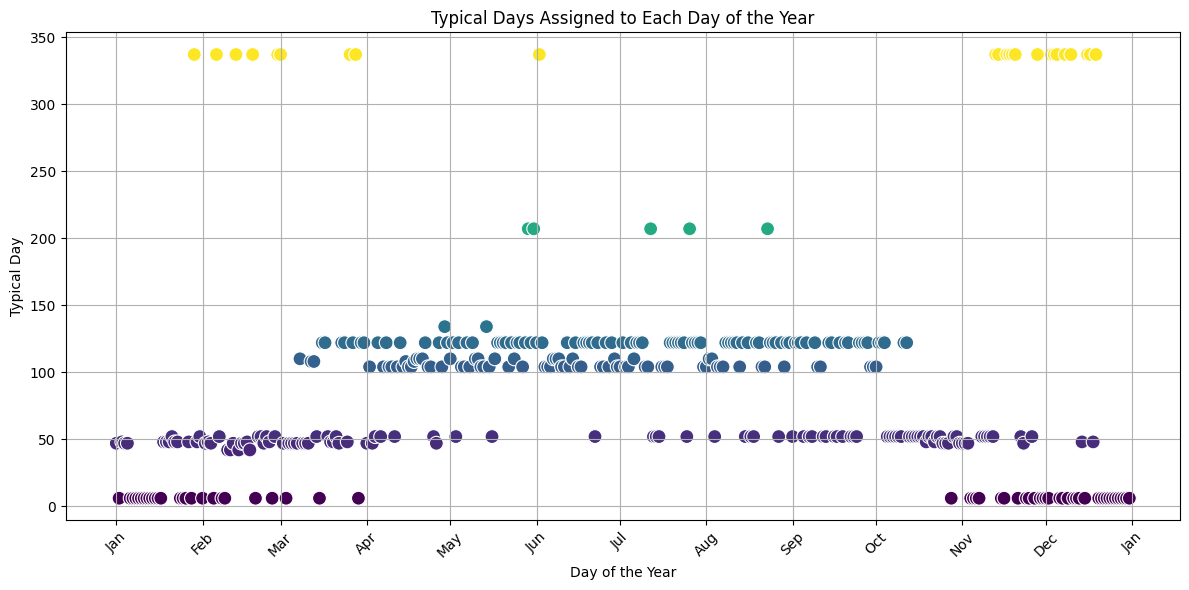

In [12]:
# plot the the typical days through the year
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
# Convert the index to datetime for better plotting
cluster_matrix.index = pd.to_datetime(cluster_matrix.index, format='%j')  # %j is the day of the year
# Create a new DataFrame for plotting
td_plot = cluster_matrix.reset_index()
td_plot.rename(columns={'index1': 'DayOfYear'}, inplace=True)
td_plot['DayOfYear'] = pd.to_datetime(td_plot['DayOfYear'], format='%j')
# Plotting
plt.figure(figsize=(12, 6))
sns.scatterplot(data=td_plot, x='DayOfYear', y='TypicalDay', hue='TypicalDay', palette='viridis', s=100, legend=None)
plt.title('Typical Days Assigned to Each Day of the Year')
plt.xlabel('Day of the Year')
plt.ylabel('Typical Day')
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))
plt.grid(True)
plt.tight_layout()
plt.show()